<xarray.Dataset> Size: 3MB
Dimensions:    (y: 292, x: 362)
Dimensions without coordinates: y, x
Data variables:
    atlmsk     (y, x) float32 423kB ...
    glomsk     (y, x) float32 423kB ...
    indmsk     (y, x) float32 423kB ...
    indpacmsk  (y, x) float32 423kB ...
    nav_lat    (y, x) float32 423kB ...
    nav_lon    (y, x) float32 423kB ...
    pacmsk     (y, x) float32 423kB ...
Attributes:
    ece-comment:  Based on SHACONEMO INPUTS_ORCA1_LIM3_PISCES_V9/eORCA_R1_sub...
    ece-origin:   UFla (SMHI) for EC-Earth
Coordinates:
    *empty*
Variables in the mask dataset: ['atlmsk', 'glomsk', 'indmsk', 'indpacmsk', 'nav_lat', 'nav_lon', 'pacmsk']
<xarray.DataArray 'atlmsk' (y: 292, x: 362)> Size: 423kB
[105704 values with dtype=float32]
Dimensions without coordinates: y, x
Attributes:
    long_name:  atlantic ocean without med sea


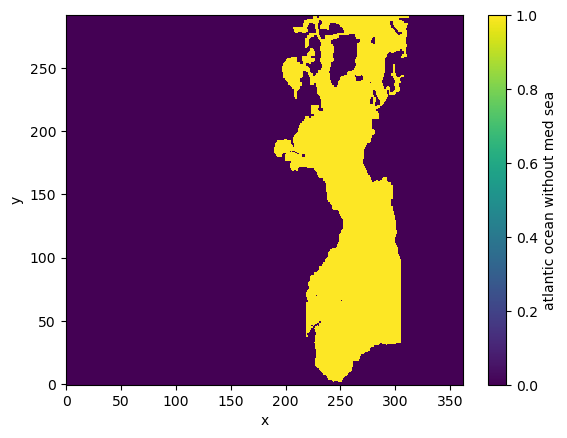

In [ ]:
import xarray as xr

# -----------------------------
# 1. Load the mask
# -----------------------------
mask_file = "/data/users/mde/FREJA/subbasins.nc"
mask_ds = xr.open_dataset(mask_file)

# -----------------------------
# 2. Inspect the dataset
# -----------------------------
print(mask_ds)  # prints dimensions, coordinates, and data variables
print(mask_ds.coords)  # prints coordinate variables

# -----------------------------
# 3. List the variables
# -----------------------------
print("Variables in the mask dataset:", list(mask_ds.data_vars))

# -----------------------------
# 4. View one of the variables (for example, the first one)
# -----------------------------
first_var_name = list(mask_ds.data_vars)[0]
mask_data = mask_ds[first_var_name]
print(mask_data)  # prints the DataArray with values and coordinates

# -----------------------------
# 5. Optional: quick plot to see the mask
# -----------------------------
mask_data.plot()




In [4]:
import xarray as xr
import numpy as np
# 1. Load the mask (auto-detect variable and align to thetao grid)
# -----------------------------
mask_file = "/data/users/mde/FREJA/subbasins.nc"
mask_ds = xr.open_dataset(mask_file)

# load thetao to get its grid
thetao_file = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
thetao = xr.open_dataset(thetao_file)['thetao']

# Auto-detect a mask variable that has lat/lon dims; fall back to the first data var
mask_vars = list(mask_ds.data_vars)
candidates = [v for v in mask_vars if (any(k in mask_ds[v].dims for k in ['latitude','lat','y','j']) and any(k in mask_ds[v].dims for k in ['longitude','lon','x','i']))]
mask_var = candidates[0] if candidates else mask_vars[0]
print("Using mask variable:", mask_var)
mask = mask_ds[mask_var].squeeze()

# -----------------------------
# 2. Align/interpolate mask to the thetao horizontal grid (nearest neighbour)
# -----------------------------
thetao_grid = thetao.isel(time=0).drop_vars([v for v in thetao.coords if v == 'time' or v == 'lev']) if 'time' in thetao.coords else thetao.isel(time=0)
# Ensure mask and thetao_grid have compatible dimensions for interpolation
if 'latitude' in mask.coords and 'longitude' in mask.coords:
    mask_on_grid = mask.interp(latitude=thetao_grid['latitude'], longitude=thetao_grid['longitude'], method='nearest')
elif 'lat' in mask.coords and 'lon' in mask.coords:
    mask_on_grid = mask.interp(lat=thetao_grid['lat'], lon=thetao_grid['lon'], method='nearest')
elif 'nav_lat' in mask_ds.data_vars and 'nav_lon' in mask_ds.data_vars:
    # Use nav_lat and nav_lon from mask_ds for interpolation
    mask_on_grid = mask.interp(
        y=thetao_grid['j'], x=thetao_grid['i'],
        kwargs={"fill_value": None},
        method='nearest'
    )
else:
    raise ValueError("Mask does not have recognizable latitude/longitude coordinates for interpolation.")

# Build a boolean mask (True inside the region). Treat non-zero & finite as inside.
mask_bool = (np.isfinite(mask_on_grid)) & (mask_on_grid != 0)

# save the mask for future reference
# mask_bool.to_netcdf("mask_bool2.nc")

# Print mask info
print(mask_bool)

Using mask variable: atlmsk
<xarray.DataArray 'atlmsk' (j: 292, i: 362)> Size: 106kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(292, 362))
Coordinates:
    y        (j) int32 1kB 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
    x        (i) int32 1kB 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362
  * j        (j) int32 1kB 1 2 3 4 5 6 7 8 9 ... 285 286 287 288 289 290 291 292
  * i        (i) int32 1kB 1 2 3 4 5 6 7 8 9 ... 355 356 357 358 359 360 361 362


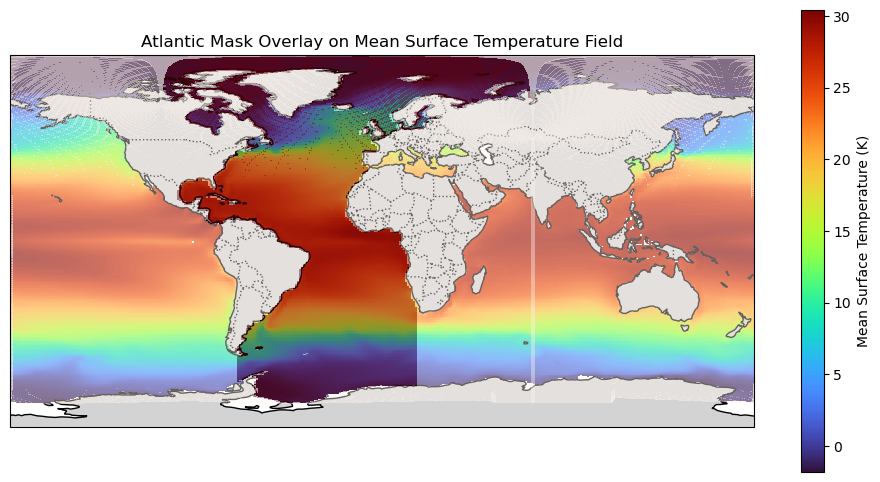

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# 1. Load datasets
# -----------------------------
thetao_file = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_file = "/data/users/frekle/mask_bool2.nc"

thetao_ds = xr.open_dataset(thetao_file)
mask_ds = xr.open_dataset(mask_file)

# Extract top layer mean for background
thetao_surf_mean = thetao_ds["thetao"].isel(lev=0).mean(dim="time")

# Extract mask
mask = mask_ds["atlmsk"]

# Get latitude and longitude from thetao dataset
lat = thetao_ds['latitude']
lon = thetao_ds['longitude']

# -----------------------------
# 2. Plot
# -----------------------------
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and land
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=0)
ax.set_global()

# Plot thetao mean as background
pcm = ax.pcolormesh(
    lon, lat, thetao_surf_mean,
    transform=ccrs.PlateCarree(),
    cmap='turbo',
    shading='auto'
)
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Mean Surface Temperature (K)')

# Plot mask overlay using thetao lat/lon
ax.pcolormesh(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    alpha=0.4,
    zorder=2
)

plt.title("Atlantic Mask Overlay on Mean Surface Temperature Field")
plt.show()


In [12]:
import xarray as xr

# --- File paths ---
thetao_path = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
so_path = "/data/projects/nckf/frekle/CMIP6_data/so/so_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_path = "/data/users/frekle/mask_bool2.nc"

# --- Output paths ---
thetao_masked_out = "/data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc"
so_masked_out = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc"

# --- Load datasets ---
ds_thetao = xr.open_dataset(thetao_path)
ds_so = xr.open_dataset(so_path)
ds_mask = xr.open_dataset(mask_path)

# --- Load mask variable (assume it's named 'atlmsk') ---
mask = ds_mask["atlmsk"]

# --- Ensure mask is boolean ---
mask = mask.astype(bool)
 
# --- Apply mask to all depth levels (3D mask) ---
thetao = ds_thetao["thetao"]
so = ds_so["so"]

# Expand mask along the vertical (lev) dimension
mask_3d = mask.broadcast_like(thetao)

# Apply mask
thetao_masked = thetao.where(mask_3d)
so_masked = so.where(mask_3d)

# --- Save masked data ---
thetao_masked.to_dataset(name="thetao").to_netcdf(thetao_masked_out)
so_masked.to_dataset(name="so").to_netcdf(so_masked_out)

print("✅ 3D masked files saved successfully:")
print(f"- {thetao_masked_out}")
print(f"- {so_masked_out}")


✅ 3D masked files saved successfully:
- /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked.nc
- /data/projects/nckf/frekle/CMIP6_data/so/so_masked.nc


In [9]:
# Mask for mlotst and msfytz

# --- File paths ---
mlotst_path = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
msftyz_path = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_Oyear_EC-Earth3_historical_r1i1p1f1_gn_185001-201412.nc"
mask_path = "/data/users/frekle/mask_bool2.nc"

# --- Output paths ---
mlotst_masked_out = "/data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc"
msftyz_masked_out = "/data/projects/nckf/frekle/CMIP6_data/msftyz/msftyz_masked.nc"

# --- Load datasets ---
ds_mlotst = xr.open_dataset(mlotst_path)
ds_msftyz = xr.open_dataset(msftyz_path)
ds_mask = xr.open_dataset(mask_path)

# --- Load mask variable (assume it's named 'atlmsk') ---
mask = ds_mask["atlmsk"]

# --- Ensure mask is boolean ---
mask = mask.astype(bool)
 
# --- Apply mask to all depth levels (3D mask) ---
mlotst = ds_mlotst["mlotst"]
msftyz = ds_msftyz["msftyz"]

# Expand mask along the vertical (lev) dimension
mask_3d_mlotst = mask.broadcast_like(mlotst)
mask_3d_msftyz = mask.broadcast_like(msftyz)

# Apply mask
mlotst_masked = mlotst.where(mask_3d_mlotst)
#msftyz_masked = msftyz.where(mask_3d_msftyz)

# --- Save masked data ---
mlotst_masked.to_dataset(name="mlotst").to_netcdf(mlotst_masked_out)
# msftyz_masked.to_dataset(name="msftyz").to_netcdf(msftyz_masked_out)

print("✅ 3D masked files saved successfully:")
print(f"- {mlotst_masked_out}")
# print(f"- {msftyz_masked_out}")


✅ 3D masked files saved successfully:
- /data/projects/nckf/frekle/CMIP6_data/mlotst/mlotst_masked.nc


### Loop through all members

🧪 Testing mask overlay on: r10i1p1f1
✅ Mask dims: ('j', 'i'), dtype: bool

✅ Masking applied in memory.
Original dims: (165, 75, 292, 362)
Masked dims:   (165, 75, 292, 362)


/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/dmidata/users/frekle/miniforge3/envs/aimoc_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)


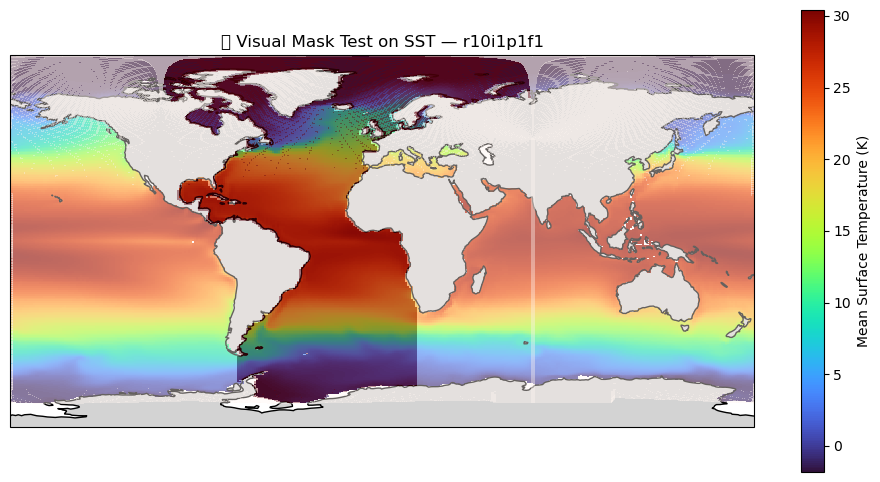


🎉 Test completed. No files were saved — this was only a visual check.


In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from glob import glob

# --- Test setup ---
src_base = "/dmidata/projects/nckf/cmip6/historical/EC-Earth3"
mask_path = "/data/users/frekle/mask_bool2.nc"

member_path = sorted(glob(f"{src_base}/r*i1p1f1"))[0]  # just first member
member = member_path.split("/")[-1]
print(f"🧪 Testing mask overlay on: {member}")

# --- Load mask ---
mask = xr.open_dataset(mask_path)["atlmsk"].astype(bool).reset_coords(drop=True)
print(f"✅ Mask dims: {mask.dims}, dtype: {mask.dtype}")

# --- Load thetao (SST) for plotting ---
thetao_src = glob(f"{member_path}/Oyear/thetao/thetao_*.nc")[0]
ds_thetao = xr.open_dataset(thetao_src)  # no chunks = fast for plotting
thetao_surf_mean = ds_thetao["thetao"].isel(lev=0).mean(dim="time")

# Get lat/lon for map
lat = ds_thetao["latitude"]
lon = ds_thetao["longitude"]

# --- Apply mask (not saving, just show result) ---
thetao_masked = ds_thetao["thetao"].where(mask)

print("\n✅ Masking applied in memory.")
print(f"Original dims: {ds_thetao['thetao'].shape}")
print(f"Masked dims:   {thetao_masked.shape}")

# --- PLOT ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
ax.set_global()

# Background SST
pcm = ax.pcolormesh(
    lon, lat, thetao_surf_mean,
    transform=ccrs.PlateCarree(),
    cmap="turbo",
    shading="auto"
)
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Mean Surface Temperature (K)')

# Mask overlay
ax.pcolormesh(
    lon,
    lat,
    mask,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    alpha=0.4,
    zorder=2
)

plt.title(f"✅ Visual Mask Test on SST — {member}")
plt.show()

print("\n🎉 Test completed. No files were saved — this was only a visual check.")



In [1]:
import os
from glob import glob
import xarray as xr

# ------------ Paths ------------
src_base = "/dmidata/projects/nckf/cmip6/historical/EC-Earth3"
dst_base = "/data/projects/nckf/frekle/CMIP6_data"
mask_path = "/data/users/frekle/mask_bool2.nc"  # dims: (j, i), var: atlmsk

# Ensure output folders exist
os.makedirs(f"{dst_base}/thetao", exist_ok=True)
os.makedirs(f"{dst_base}/so", exist_ok=True)

# ------------ Load mask once ------------
ds_mask = xr.open_dataset(mask_path)
mask = ds_mask["atlmsk"].astype(bool)  # (j, i)

# ------------ Find ensemble members ------------
members = sorted(glob(f"{src_base}/r*i1p1f1"))

if not members:
    raise RuntimeError("No ensemble member folders found under "
                       f"{src_base}/r*i1p1f1")

for member_path in members:
    member = os.path.basename(member_path)  # e.g., r1i1p1f1
    print(f"\n🔄 Processing {member} ...")

    # Locate input files (one per var)
    thetao_src_list = glob(f"{member_path}/Oyear/thetao/thetao_*.nc")
    so_src_list     = glob(f"{member_path}/Oyear/so/so_*.nc")

    if not thetao_src_list or not so_src_list:
        print(f"⚠️  Missing thetao/so input for {member} — skipping.")
        continue

    thetao_src = thetao_src_list[0]
    so_src     = so_src_list[0]

    # Open datasets (no compression/chunking; same approach as your single-member script)
    ds_thetao = xr.open_dataset(thetao_src)
    ds_so     = xr.open_dataset(so_src)

    thetao = ds_thetao["thetao"]  # (time, lev, j, i)
    so     = ds_so["so"]          # (time, lev, j, i)

    # --- 3D broadcast of mask (exactly as in your working example) ---
    mask_3d = mask.broadcast_like(thetao)  # expands to (time, lev, j, i)

    # Apply mask
    thetao_masked = thetao.where(mask_3d)
    so_masked     = so.where(mask_3d)

    # Output paths (overwrite if exists)
    thetao_out = f"{dst_base}/thetao/thetao_masked_{member}.nc"
    so_out     = f"{dst_base}/so/so_masked_{member}.nc"

    # Save (no compression)
    thetao_masked.to_dataset(name="thetao").to_netcdf(thetao_out)
    so_masked.to_dataset(name="so").to_netcdf(so_out)

    print(f"✅ Saved: {thetao_out}")
    print(f"✅ Saved: {so_out}")

print("\n🎉 All ensemble members processed (SST + SSS, 3D mask applied, no compression).")




🔄 Processing r10i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r10i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r10i1p1f1.nc

🔄 Processing r11i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r11i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r11i1p1f1.nc

🔄 Processing r12i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r12i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r12i1p1f1.nc

🔄 Processing r13i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r13i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r13i1p1f1.nc

🔄 Processing r14i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_masked_r14i1p1f1.nc
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/so/so_masked_r14i1p1f1.nc

🔄 Processing r15i1p1f1 ...
✅ Saved: /data/projects/nckf/frekle/CMIP6_data/thetao/thetao_m

KeyError: 'lon'

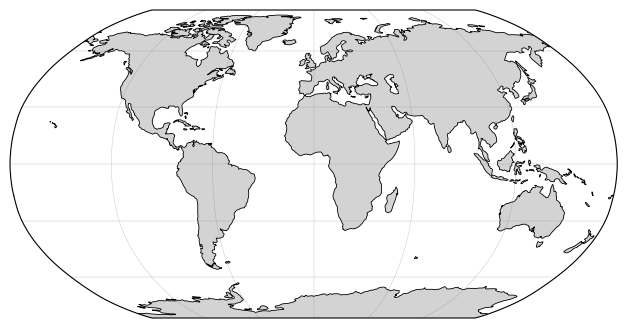

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ==========================================================
# 1. Load EN4 data
# ==========================================================
en4_file = "/data/projects/nckf/frekle/CMIP6_data/so/EN4_SSS_surface_1900_2014_Atl.nc"
ds = xr.open_dataset(en4_file)

# Select salinity for a given year (surface only)
year = 2000
sss = ds["salinity_masked"].sel(time=str(year), method="nearest")

# ==========================================================
# 2. Plot with Cartopy
# ==========================================================
plt.figure(figsize=(9, 4))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()

# Add coastlines and grid
ax.coastlines(linewidth=0.6)
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5)

# Plot salinity
im = ax.pcolormesh(
    sss["lon"], sss["lat"], sss,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto"
)

# Colorbar and title
plt.colorbar(im, orientation="horizontal", pad=0.05, label="Salinity (psu)")
plt.title(f"EN4 Surface Salinity ({year})", fontsize=12)
plt.tight_layout()
plt.show()


In [16]:
"""
Mask EN4 surface salinity to the Atlantic domain
and save as NetCDF.

Freja Klejnstrup — 2025
"""

import xarray as xr
import numpy as np
import os
from scipy.interpolate import RegularGridInterpolator

# ==========================================================
# 1. Paths
# ==========================================================
en4_file = "/data/projects/nckf/frekle/obs_data/EN4_SSS_surface_1900_2014.nc"
mask_file = "/data/users/frekle/mask_bool2.nc"
model_ref = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked_r1i1p1f1.nc"
out_file  = "/data/projects/nckf/frekle/CMIP6_data/so/EN4_SSS_surface_1900_2014_Atl.nc"

os.makedirs(os.path.dirname(out_file), exist_ok=True)

# ==========================================================
# 2. Load data
# ==========================================================
print("📥 Loading EN4 salinity and Atlantic mask...")
en4 = xr.open_dataset(en4_file)
en4_sss = en4["salinity"].sel(time=slice("1900", "2014"))

mask_ds = xr.open_dataset(mask_file)
ds_ref = xr.open_dataset(model_ref)

# Detect mask variable name
mask_var = [v for v in mask_ds.data_vars if mask_ds[v].dtype == bool or mask_ds[v].dtype == np.int_][0]
mask = mask_ds[mask_var]

print(f"✅ Mask variable detected: {mask_var} | shape = {mask.shape}")

# ==========================================================
# 3. Interpolation function
# ==========================================================
def regrid_to_model(en4_field, model_lat, model_lon):
    """Interpolate EN4 (regular lat/lon) to model (curvilinear lat/lon)."""
    en4_lat = en4_field["lat"].values
    en4_lon = en4_field["lon"].values
    data = en4_field.values

    f_interp = RegularGridInterpolator((en4_lat, en4_lon), data, bounds_error=False, fill_value=np.nan)
    points = np.array([model_lat.values.ravel(), model_lon.values.ravel()]).T
    new_vals = f_interp(points).reshape(model_lat.shape)

    return xr.DataArray(
        new_vals,
        dims=("j", "i"),
        coords={"j": model_lat["j"], "i": model_lon["i"]},
        attrs=en4_field.attrs,
    )

# ==========================================================
# 4. Regrid EN4 to EC-Earth3 grid and apply mask
# ==========================================================
print("⏳ Regridding EN4 to EC-Earth3 grid...")
model_lat = ds_ref["latitude"]
model_lon = ds_ref["longitude"]

# Apply regridding for each time step
masked_list = []
for t in en4_sss.time:
    field_t = en4_sss.sel(time=t)
    regridded = regrid_to_model(field_t, model_lat, model_lon)
    masked_list.append(regridded.where(mask))

masked_en4 = xr.concat(masked_list, dim=en4_sss["time"])
masked_en4.name = "salinity"
masked_en4.attrs["description"] = "EN4 salinity masked to Atlantic domain (EC-Earth3 grid)"

print("✅ EN4 successfully regridded and masked.")

# ==========================================================
# 5. Save new masked EN4 file
# ==========================================================
masked_en4.to_netcdf(out_file)
print(f"💾 Saved masked EN4 dataset to:\n   {out_file}")


📥 Loading EN4 salinity and Atlantic mask...
✅ Mask variable detected: atlmsk | shape = (292, 362)
⏳ Regridding EN4 to EC-Earth3 grid...


KeyboardInterrupt: 

/tmp/ipykernel_523953/2270346142.py:17: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  en4["time"] = xr.cftime_range(start="1900", periods=len(en4.time), freq="M")
/tmp/ipykernel_523953/2270346142.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.
  en4["time"] = xr.cftime_range(start="1900", periods=len(en4.time), freq="M")


Grid shape: (1380, 292, 362)
NaN fraction: 0.9339854688564293
Value range: 3.0667191433138097 40.305662063406594


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


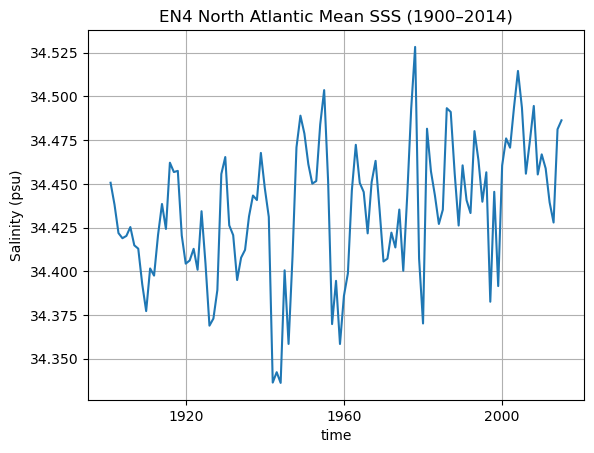

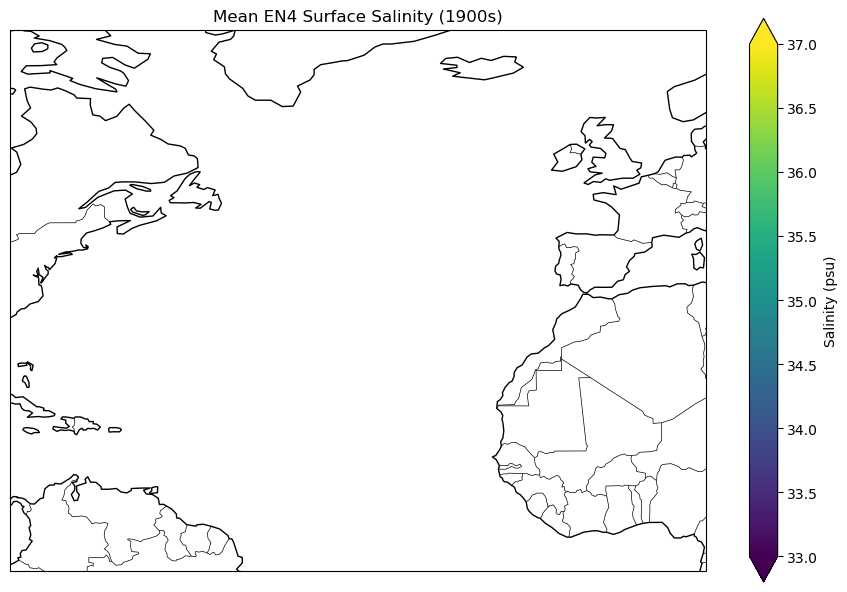

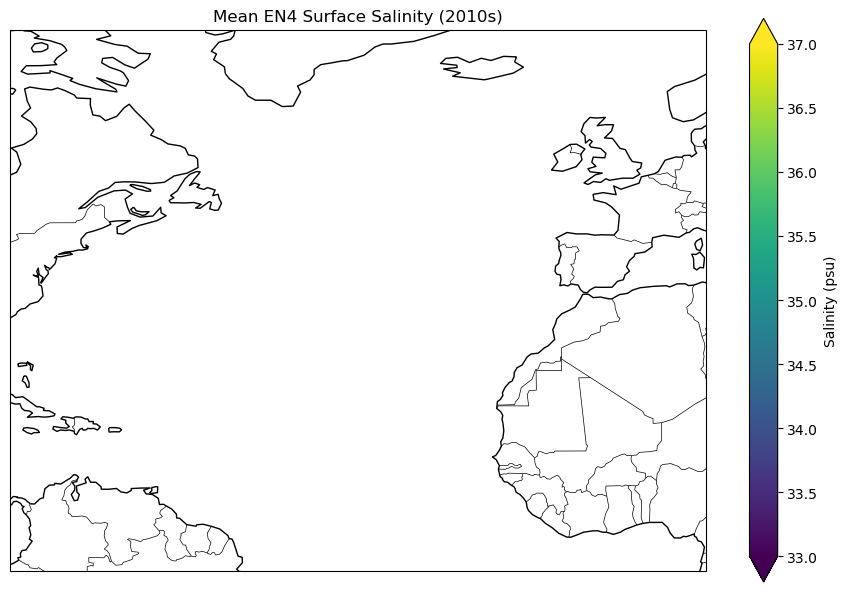

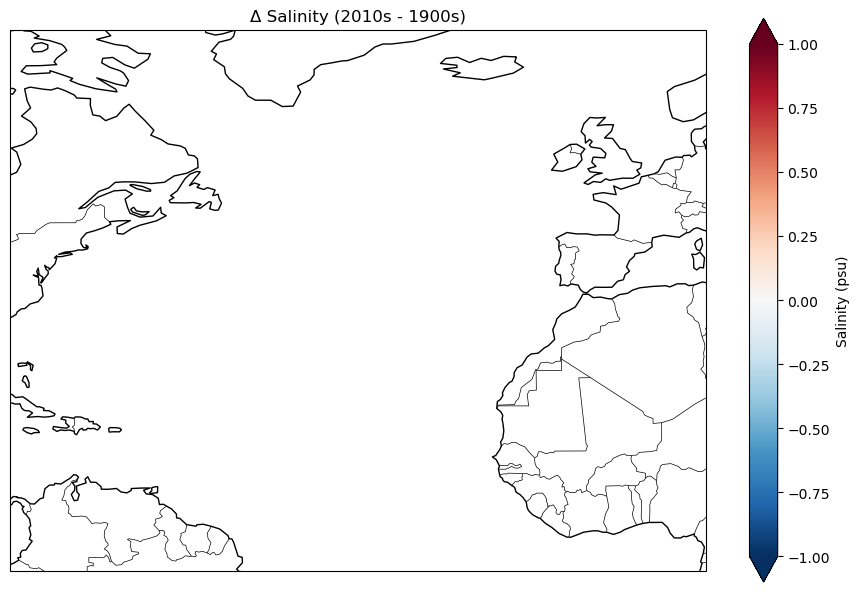

Trend stats: -0.17384355367375817 0.1558589249449358 0.004781609648480566
Valid cells: 6978


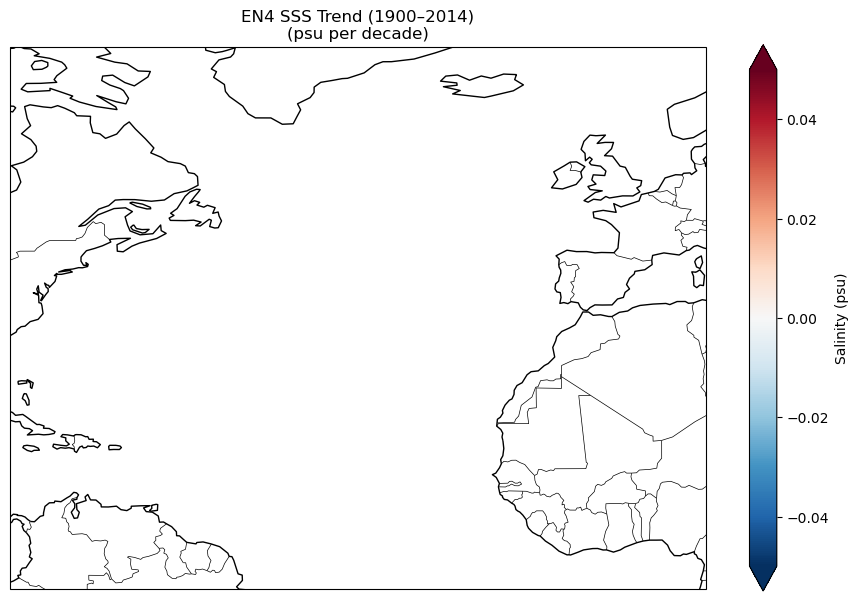

In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# File paths
# -----------------------------
en4_path = "/data/projects/nckf/frekle/CMIP6_data/so/EN4_SSS_surface_1900_2014_Atl.nc"
ref_path = "/data/projects/nckf/frekle/CMIP6_data/so/so_masked_r1i1p1f1.nc"

# -----------------------------
# Load EN4 and attach coordinates
# -----------------------------
en4 = xr.open_dataset(en4_path)
en4["time"] = xr.cftime_range(start="1900", periods=len(en4.time), freq="M")
sss = en4["salinity_masked"]

# Attach lat/lon from model grid as coordinates
ref = xr.open_dataset(ref_path)
lat = ref["latitude"]
lon = ref["longitude"]
sss = sss.assign_coords(latitude=lat, longitude=lon)
ref.close()

# -----------------------------
# Apply mask (latitude only)
# -----------------------------
sss = sss.where((sss.latitude > 0) & (sss.latitude < 70))

# -----------------------------
# Diagnostics
# -----------------------------
print("Grid shape:", sss.shape)
print("NaN fraction:", float(np.isnan(sss).mean()))
print("Value range:", float(sss.min(skipna=True)), float(sss.max(skipna=True)))

# -----------------------------
# Yearly mean and area mean
# -----------------------------
sss_yearly = sss.resample(time="Y").mean()
sss_area_mean = sss_yearly.mean(("j","i"), skipna=True)

plt.figure()
sss_area_mean.plot()
plt.title("EN4 North Atlantic Mean SSS (1900–2014)")
plt.ylabel("Salinity (psu)")
plt.grid(True)
plt.show()

# -----------------------------
# First/last decade mean maps
# -----------------------------
first_decade = sss.sel(time=slice("1900-01-01", "1909-12-31")).mean("time")
last_decade = sss.sel(time=slice("2005-01-01", "2014-12-31")).mean("time")
diff = last_decade - first_decade

def plot_map(data, title, vmin=None, vmax=None, cmap="viridis"):
    plt.figure(figsize=(9,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, transform=ccrs.PlateCarree(),
              cmap=cmap, vmin=vmin, vmax=vmax,
              cbar_kwargs={"label": "Salinity (psu)"})
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_extent([-80, 10, 0, 70], crs=ccrs.PlateCarree())
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_map(first_decade, "Mean EN4 Surface Salinity (1900s)", vmin=33, vmax=37)
plot_map(last_decade, "Mean EN4 Surface Salinity (2010s)", vmin=33, vmax=37)
plot_map(diff, "Δ Salinity (2010s - 1900s)", vmin=-1, vmax=1, cmap="RdBu_r")

# -----------------------------
# Compute linear trend (robust)
# -----------------------------
years = sss_yearly["time"].dt.year.values

def trend_func(y):
    mask = np.isfinite(y)
    if mask.sum() < 10:
        return np.nan
    slope = np.polyfit(years[mask], y[mask], 1)[0] * 10  # per decade
    return slope

trend = xr.apply_ufunc(
    trend_func,
    sss_yearly,
    input_core_dims=[["time"]],
    output_dtypes=[float],
    vectorize=True
)

print("Trend stats:", float(trend.min(skipna=True)),
      float(trend.max(skipna=True)),
      float(trend.mean(skipna=True)))
print("Valid cells:", int(np.isfinite(trend).sum()))

# -----------------------------
# Plot trend map
# -----------------------------
if np.isfinite(trend).sum() > 0:
    plot_map(trend, "EN4 SSS Trend (1900–2014)\n(psu per decade)",
             vmin=-0.05, vmax=0.05, cmap="RdBu_r")
else:
    print("⚠️ No valid trend values — likely over-masking or NaN grid.")






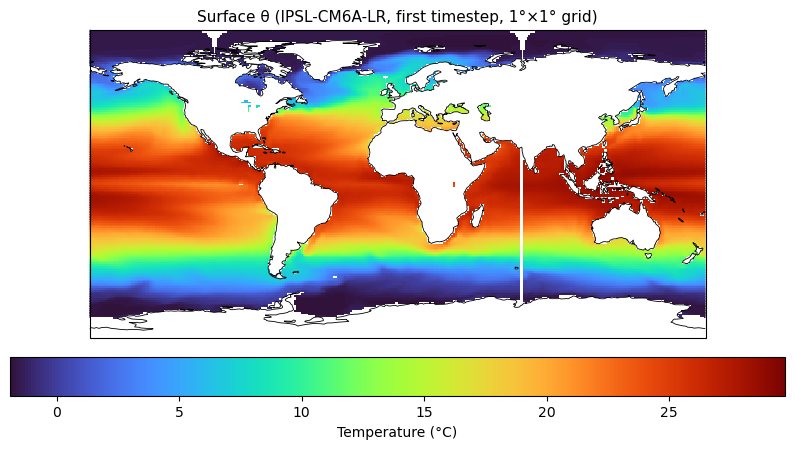

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# File path
f = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao_3D_regrid_IPSL-CM6A-LR_r1i1p1f1.nc"

# Open the dataset
ds = xr.open_dataset(f)
da = ds["thetao"]

# Pick the first time step and surface level (0 m)
surface = da.isel(time=0, olevel=0)

# Plot
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
pc = ax.pcolormesh(surface.lon, surface.lat, surface, transform=ccrs.PlateCarree(), cmap="turbo")
ax.coastlines(linewidth=0.6)
ax.set_title("Surface θ (IPSL-CM6A-LR, first timestep, 1°×1° grid)", fontsize=11)
cb = plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.05, label="Temperature (°C)")
plt.show()


In [5]:
import xarray as xr
import numpy as np

datafile = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao_3D_regrid_IPSL-CM6A-LR_r1i1p1f1.nc"
maskfile = "/data/users/frekle/mask_bool_IPSL_1deg.nc"

# Open both
ds = xr.open_dataset(datafile)
da = ds["thetao"].isel(time=0, olevel=0)
mask = xr.open_dataset(maskfile)
mask_var = list(mask.data_vars)[0]  # automatically pick first variable
m = mask[mask_var]

# Print coordinate info
print("\n--- DATA grid ---")
print("lat:", da.lat.values[:5], "...", da.lat.values[-5:])
print("lon:", da.lon.values[:5], "...", da.lon.values[-5:])

print("\n--- MASK grid ---")
print("lat:", m.lat.values[:5], "...", m.lat.values[-5:])
print("lon:", m.lon.values[:5], "...", m.lon.values[-5:])

print("\nLongitude range difference:",
      da.lon.values[0], "→", da.lon.values[-1],
      "vs", m.lon.values[0], "→", m.lon.values[-1])
print("Longitude step:", np.diff(da.lon.values[:2])[0])





--- DATA grid ---
lat: [-89.5 -88.5 -87.5 -86.5 -85.5] ... [85.5 86.5 87.5 88.5 89.5]
lon: [0. 1. 2. 3. 4.] ... [355. 356. 357. 358. 359.]

--- MASK grid ---
lat: [-89.5 -88.5 -87.5 -86.5 -85.5] ... [85.5 86.5 87.5 88.5 89.5]
lon: [0.5 1.5 2.5 3.5 4.5] ... [355.5 356.5 357.5 358.5 359.5]

Longitude range difference: 0.0 → 359.0 vs 0.5 → 359.5
Longitude step: 1.0


In [6]:
import xarray as xr

maskfile = "/data/users/frekle/mask_bool_IPSL_1deg.nc"
m = xr.open_dataset(maskfile)
mask_var = list(m.data_vars)[0]
mask = m[mask_var]

# Shift longitude centers back by 0.5°
mask = mask.assign_coords(lon=(mask.lon - 0.5) % 360)

# Save corrected mask
mask_corrected = mask.sortby("lon")
mask_corrected.to_netcdf("/data/users/frekle/mask_bool_IPSL_1deg_aligned.nc")
print("✅ Saved:", "/data/users/frekle/mask_bool_IPSL_1deg_aligned.nc")


✅ Saved: /data/users/frekle/mask_bool_IPSL_1deg_aligned.nc


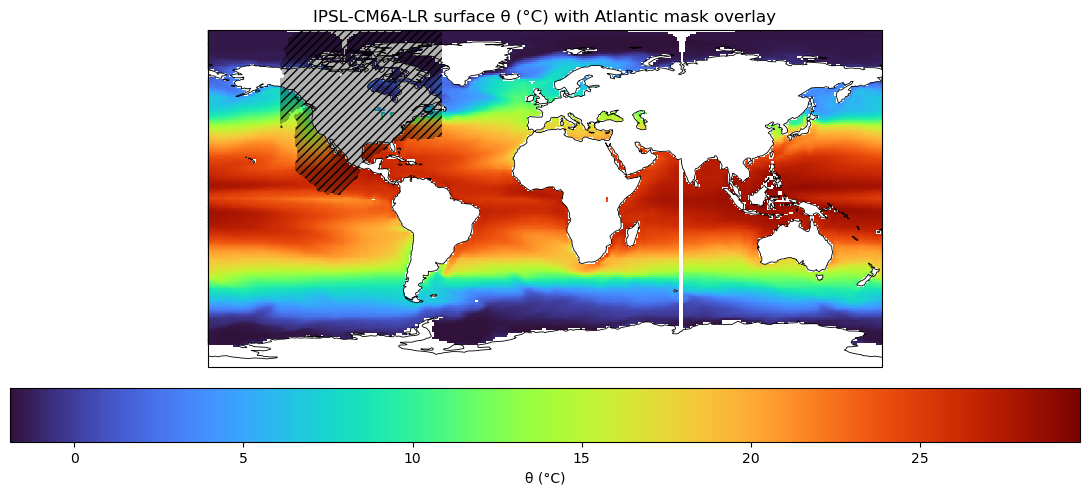

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ---------------- FILE PATHS ----------------
datafile = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao_3D_regrid_IPSL-CM6A-LR_r1i1p1f1.nc"
maskfile = "/data/users/frekle/mask_bool_EC-Earth3.nc"

# ---------------- LOAD DATA ----------------
ds = xr.open_dataset(datafile)
da = ds["thetao"].isel(time=0, olevel=0)   # first time step, surface

mask = xr.open_dataarray(maskfile)
# If variable name is different (e.g. 'atlmsk'), open_dataset and select:
# mask = xr.open_dataset(maskfile)["atlmsk"]
mask = mask.astype(float)

# ---------------- PLOT ----------------
fig = plt.figure(figsize=(11,5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Base layer: temperature field
pcm = ax.pcolormesh(
    da["lon"], da["lat"], da,
    cmap="turbo", transform=ccrs.PlateCarree()
)
cb = plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05, label="θ (°C)")
ax.set_title("IPSL-CM6A-LR surface θ (°C) with Atlantic mask overlay")

# Overlay: transparent mask (gray)
mask_plot = mask.where(mask > 0.5)
ax.contourf(
    mask_plot["i"], mask_plot["j"], mask_plot,
    levels=[0.5,1.5], colors="none",
    hatches=["////"], transform=ccrs.PlateCarree(), alpha=0.3
)

ax.coastlines(linewidth=0.6)
plt.tight_layout()
plt.show()


In [20]:
import xarray as xr
import numpy as np

# ---- File paths ----
datafile = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao_3D_regrid_IPSL-CM6A-LR_r1i1p1f1.nc"
mask_out = "/data/users/frekle/mask_bool_IPSL_fromdata.nc"

# ---- Load dataset ----
ds = xr.open_dataset(datafile)
da = ds["thetao"]

# ---- Create ocean mask ----
# Where the temperature is finite, define ocean = 1; else 0
mask = xr.where(np.isfinite(da.isel(time=0, olevel=0)), 1, 0).astype(np.int8)

# Keep lat/lon coordinates
mask = mask.rename("atlmsk")
mask.attrs["description"] = "Atlantic/ocean mask derived from IPSL-CM6A-LR thetao grid (1°x1°)"
mask.attrs["note"] = "1 = ocean, 0 = land (based on finite thetao values)"

# ---- Save ----
mask.to_netcdf(mask_out)
print("✅ New mask saved:", mask_out)



✅ New mask saved: /data/users/frekle/mask_bool_IPSL_fromdata.nc


✅ Saved: /data/projects/nckf/frekle/mask_bool_IPSL.nc


NameError: name 'mask_plot' is not defined

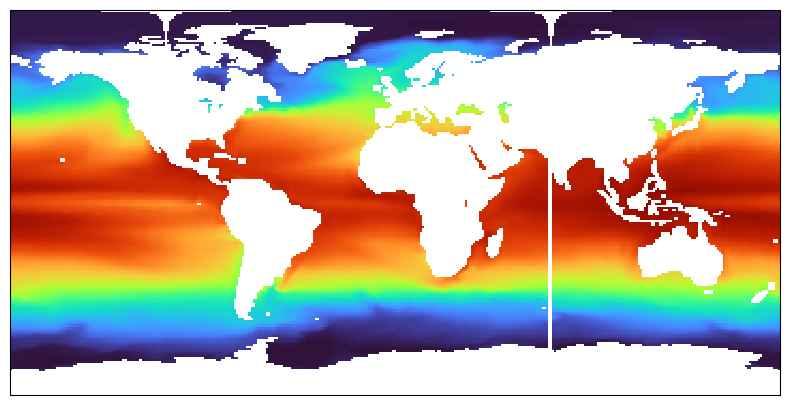

In [6]:
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ---------------- FILE PATHS ----------------
subbasins = "/data/users/mde/FREJA/subbasins.nc"  # supervisor's mask
ipsl_grid = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao_3D_regrid_IPSL-CM6A-LR_r1i1p1f1.nc"
out_mask  = "/data/projects/nckf/frekle/mask_bool_IPSL.nc"

# ---------------- LOAD SOURCE (tripolar grid) ----------------
ds_sub = xr.open_dataset(subbasins)
atl = ds_sub["atlmsk"].load()
lon_src = (ds_sub["nav_lon"].load() % 360)  # ensure 0–360 range
lat_src = ds_sub["nav_lat"].load()

# Flatten and clean
atl_vals = atl.values.ravel()
lon_vals = lon_src.values.ravel()
lat_vals = lat_src.values.ravel()
good = np.isfinite(atl_vals) & np.isfinite(lon_vals) & np.isfinite(lat_vals)
atl_vals, lon_vals, lat_vals = atl_vals[good], lon_vals[good], lat_vals[good]

# ---------------- LOAD TARGET (IPSL 1°×1° grid) ----------------
ref = xr.open_dataset(ipsl_grid)
lon_t = ref["lon"].values
lat_t = ref["lat"].values
lon_t2, lat_t2 = np.meshgrid(lon_t, lat_t)
lon_t2 = lon_t2 % 360

# ---------------- KD-TREE NEAREST NEIGHBOUR ----------------
def sph2cart(lon_deg, lat_deg):
    lon = np.deg2rad(lon_deg)
    lat = np.deg2rad(lat_deg)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return np.column_stack((x, y, z))

src_xyz = sph2cart(lon_vals, lat_vals)
tree = cKDTree(src_xyz)

tgt_xyz = sph2cart(lon_t2.ravel(), lat_t2.ravel())
_, idx = tree.query(tgt_xyz, k=1)
atl_on_tgt = atl_vals[idx].reshape(lat_t2.shape)

# Threshold to boolean mask
mask_ipsl = (atl_on_tgt >= 0.5).astype(np.int8)

# ---------------- SAVE MASK ----------------
da_mask = xr.DataArray(
    mask_ipsl,
    dims=("lat", "lon"),
    coords={"lat": ref["lat"], "lon": ref["lon"]},
    name="atlmsk"
)
da_mask.attrs.update({
    "long_name": "Atlantic mask from subbasins remapped to IPSL 1x1 grid",
    "source": subbasins,
    "method": "KD-tree nearest neighbour on sphere",
    "note": "1 = Atlantic Ocean, 0 = elsewhere"
})
da_mask.to_netcdf(out_mask)
print("✅ Saved:", out_mask)

# ---------------- QUICK VISUAL CHECK ----------------
surf = ref["thetao"].isel(time=0, olevel=0)
fig, ax = plt.subplots(figsize=(11,5), subplot_kw={"projection": ccrs.PlateCarree()})
pcm = ax.pcolormesh(surf.lon, surf.lat, surf, cmap="turbo", transform=ccrs.PlateCarree())
ax.contour(mask_plot["i"], mask_plot["j"], mask_plot,
    levels=[0.5,1.5], colors="none",
    hatches=["////"], transform=ccrs.PlateCarree(), alpha=0.3)
ax.coastlines()
ax.set_title("IPSL θ (surface) + Atlantic mask from subbasins (NN on sphere)")
plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05)
plt.show()




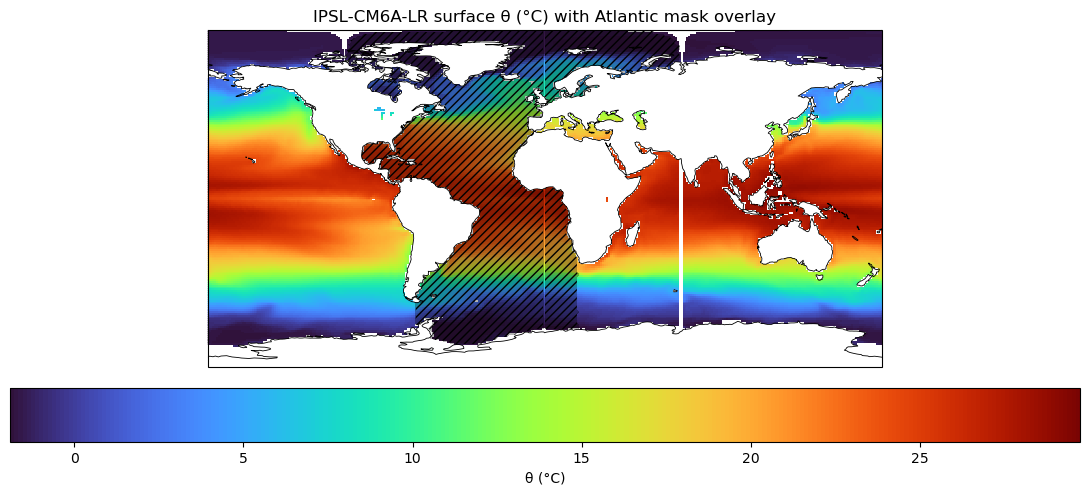

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ---------------- FILE PATHS ----------------
datafile = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao_3D_regrid_IPSL-CM6A-LR_r1i1p1f1.nc"
maskfile = "/data/projects/nckf/frekle/mask_bool_IPSL.nc"

# ---------------- LOAD ----------------
ds = xr.open_dataset(datafile)
da = ds["thetao"].isel(time=0, olevel=0)  # surface at first timestep
mask = xr.open_dataarray(maskfile).astype(float)

# ---------------- PLOT ----------------
fig = plt.figure(figsize=(11, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Base layer: SST field
pcm = ax.pcolormesh(
    da["lon"], da["lat"], da,
    cmap="turbo", transform=ccrs.PlateCarree()
)
plt.colorbar(pcm, ax=ax, orientation="horizontal", pad=0.05, label="θ (°C)")

# Overlay: transparent Atlantic mask with hatching
mask_plot = mask.where(mask > 0.5)
ax.contourf(
    mask_plot["lon"], mask_plot["lat"], mask_plot,
    levels=[0.5, 1.5],
    colors="none",  # transparent base
    hatches=["////"],  # diagonal stripes
    transform=ccrs.PlateCarree(),
    alpha=0.3
)

ax.coastlines(linewidth=0.6)
ax.set_title("IPSL-CM6A-LR surface θ (°C) with Atlantic mask overlay")
plt.tight_layout()
plt.show()


In [13]:
import xarray as xr
import numpy as np
import os

def apply_mask(infile, maskfile, outfile, varname):
    print(f"\n🌀 Applying mask to {infile}")
    ds = xr.open_dataset(infile)
    da = ds[varname]

    # --- Load and align mask ---
    mask = xr.open_dataarray(maskfile)
    if mask.dtype != bool:
        mask = mask > 0.5

    # Interpolate if needed (to ensure matching grid)
    if not np.array_equal(mask.lon, da.lon) or not np.array_equal(mask.lat, da.lat):
        print("   🔧 Interpolating mask to match data grid...")
        mask = mask.interp(lat=da.lat, lon=da.lon)

    # Expand mask along depth if necessary
    if "olevel" in da.dims:
        mask3d = mask.broadcast_like(da.isel(time=0))
    else:
        mask3d = mask

    # --- Apply mask ---
    masked = da.where(mask3d)

    # --- Wrap in dataset ---
    masked_ds = masked.to_dataset(name=varname)

    # --- Prepare compression safely ---
    comp = dict(zlib=True, complevel=3, shuffle=True)
    enc = {v: comp for v in masked_ds.data_vars if v in [varname, "time_bnds", "olevel_bnds", "area"]}

    # --- Save file ---
    masked_ds.to_netcdf(outfile, encoding=enc)
    print(f"✅ Saved masked file: {outfile}")

    # --- Quick sanity check ---
    print("   Masked NaN fraction:", float(masked.isnull().mean().values))



In [16]:
regridded_file = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao/thetao_regrid_r1i1p1f1.nc"
maskfile = "/data/projects/nckf/frekle/mask_bool_IPSL.nc"   # ✅ correct mask
out_masked_file = "/data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao/thetao_masked_r1i1p1f1.nc"

apply_mask(regridded_file, maskfile, out_masked_file, "thetao")




🌀 Applying mask to /data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao/thetao_regrid_r1i1p1f1.nc
✅ Saved masked file: /data/projects/nckf/frekle/CMIP6_data/IPSL-CM6A-LR/thetao/thetao_masked_r1i1p1f1.nc
   Masked NaN fraction: 0.8520637860082304


In [20]:
import xarray as xr
import numpy as np
import os

# -------------------------------
# CONFIGURATION
# -------------------------------
model = "IPSL-CM6A-LR"
var = "thetao"   # or "so"
base_dir = f"/data/projects/nckf/frekle/CMIP6_data/{model}/{var}"
maskfile = "/data/projects/nckf/frekle/mask_bool_IPSL.nc"  # ✅ your working mask

# Load mask once
mask = xr.open_dataset(maskfile)["atlmsk"]
mask = (mask > 0.5)
print(f"✅ Loaded mask: {mask.shape}")

# -------------------------------
# FUNCTION
# -------------------------------
def apply_mask(infile, mask, outfile, varname):
    """Apply Atlantic mask and save cleaned dataset."""
    try:
        ds = xr.open_dataset(infile)
        if varname not in ds:
            print(f"⚠️ Variable {varname} not found in {infile}")
            return

        da = ds[varname]
        masked = da.where(mask)
        masked_ds = masked.to_dataset(name=varname)

        # Copy metadata
        masked_ds.attrs.update(ds.attrs)
        masked_ds[varname].attrs.update(da.attrs)

        # Save safely
        masked_ds.to_netcdf(outfile)
        print(f"✅ Masked & saved: {os.path.basename(outfile)}")

    except PermissionError:
        print(f"⛔ Skipping {os.path.basename(outfile)} — no write permission.")
    except Exception as e:
        print(f"❌ Error with {os.path.basename(outfile)}: {e}")

# -------------------------------
# LOOP OVER MEMBERS
# -------------------------------
files = sorted([
    f for f in os.listdir(base_dir)
    if f.startswith(f"{var}_regrid_r") and f.endswith(".nc")
])

print(f"\n🔍 Found {len(files)} regridded files:")
for f in files:
    print("  ", f)

for f in files:
    infile = os.path.join(base_dir, f)
    member = f.split("_regrid_")[-1].replace(".nc", "")
    outfile = os.path.join(base_dir, f"{var}_masked_{member}.nc")

    # Check write permission before attempting to overwrite
    if os.path.exists(outfile) and not os.access(outfile, os.W_OK):
        print(f"⛔ Skipping (no permission): {outfile}")
        continue

    apply_mask(infile, mask, outfile, var)

print("\n🎯 Done! All accessible files were masked successfully.")




✅ Loaded mask: (180, 360)

🔍 Found 26 regridded files:
   thetao_regrid_r10i1p1f1.nc
   thetao_regrid_r11i1p1f1.nc
   thetao_regrid_r12i1p1f1.nc
   thetao_regrid_r13i1p1f1.nc
   thetao_regrid_r14i1p1f1.nc
   thetao_regrid_r15i1p1f1.nc
   thetao_regrid_r16i1p1f1.nc
   thetao_regrid_r17i1p1f1.nc
   thetao_regrid_r18i1p1f1.nc
   thetao_regrid_r19i1p1f1.nc
   thetao_regrid_r1i1p1f1.nc
   thetao_regrid_r20i1p1f1.nc
   thetao_regrid_r21i1p1f1.nc
   thetao_regrid_r22i1p1f1.nc
   thetao_regrid_r23i1p1f1.nc
   thetao_regrid_r24i1p1f1.nc
   thetao_regrid_r25i1p1f1.nc
   thetao_regrid_r26i1p1f1.nc
   thetao_regrid_r2i1p1f1.nc
   thetao_regrid_r3i1p1f1.nc
   thetao_regrid_r4i1p1f1.nc
   thetao_regrid_r5i1p1f1.nc
   thetao_regrid_r6i1p1f1.nc
   thetao_regrid_r7i1p1f1.nc
   thetao_regrid_r8i1p1f1.nc
   thetao_regrid_r9i1p1f1.nc
✅ Masked & saved: thetao_masked_r10i1p1f1.nc
✅ Masked & saved: thetao_masked_r11i1p1f1.nc
✅ Masked & saved: thetao_masked_r12i1p1f1.nc
✅ Masked & saved: thetao_masked_r13i1p1